# Reflect Tables into SQLAlchemy ORM

In [39]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [98]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [8]:
for c in Station.__table__.columns:
    print(c)

station.id
station.station
station.name
station.latitude
station.longitude
station.elevation


In [9]:
for c in Measurement.__table__.columns:
    print(c)

measurement.id
measurement.station
measurement.date
measurement.prcp
measurement.tobs


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Get data for one year from the last date of the dataset
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()
# Pandas and plot
within_year_df = pd.DataFrame(results, columns=['date', 'precipitation'])
# drop=True by default, but not working as of 11/29/2019
within_year_df.set_index(within_year_df['date'], inplace=True)
within_year_df.drop(columns=['date'], inplace=True)
within_year_df.sort_values('date')
within_year_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


<IPython.core.display.Javascript object>


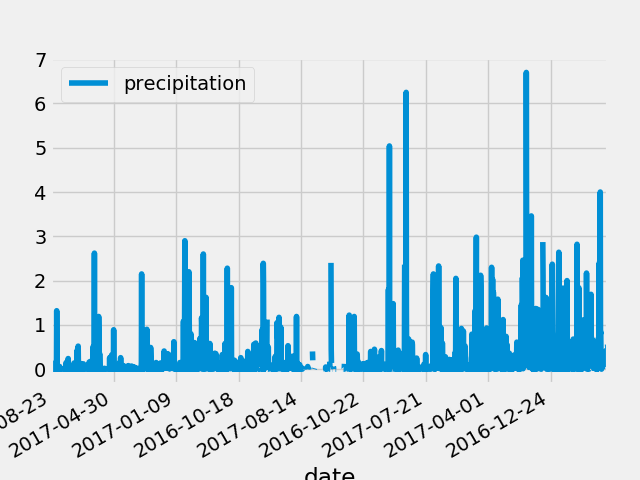

In [159]:
fig = within_year_df.plot().get_figure()
fig.autofmt_xdate()
fig.savefig("Images/jw_precipitation.png")

In [21]:
within_year_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [13]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

most_active_station = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station[0]).all()

[(54.0, 85.0, 71.66378066378067)]

<IPython.core.display.Javascript object>


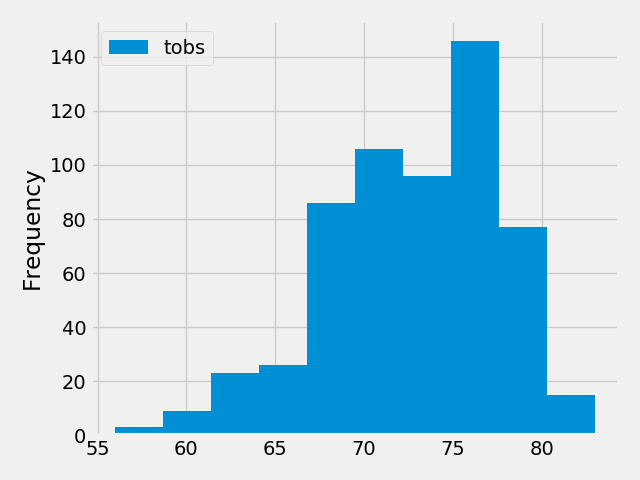

In [160]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Using 'one_year_ago' from before
results = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station[0]).\
    filter(Measurement.date >= one_year_ago).all()

active_station_year_df = pd.DataFrame(results, columns=['tobs'])
active_station_year_df.plot.hist()
plt.tight_layout()
plt.savefig("Images/jw_station-histogram.png")

In [20]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# For the trip
start = dt.date(2018, 1, 1)
end = dt.date(2018, 1, 7)

# Get range we want for last year, will be used for later
prev_year_start = start - dt.timedelta(days=365)
prev_year_end = end - dt.timedelta(days=365)

In [22]:
tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"),
                             prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

62.0 68.36585365853658 74.0


<IPython.core.display.Javascript object>


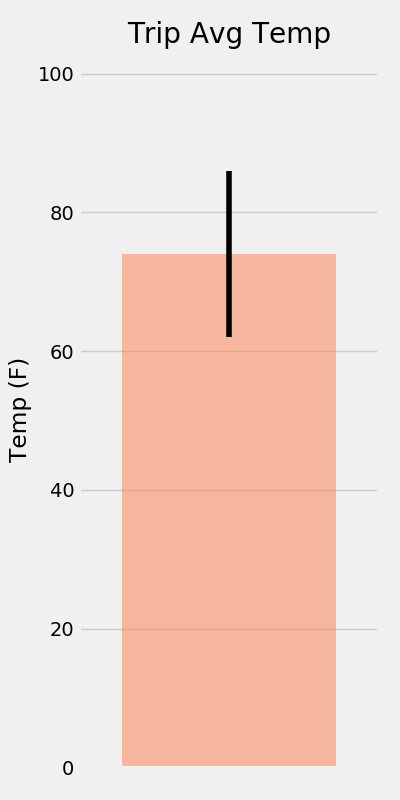

In [161]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = tmax-tmin
width = 1
fig, ax = plt.subplots(figsize=plt.figaspect(2))

bar = ax.bar(width, tmax, yerr=yerr, 
             alpha=0.5, color='coral', align='center')
ax.set(xticks=range(width), xticklabels='a', title='Trip Avg Temp', ylabel='Temp (F)')
fig.tight_layout()
ax.margins(0.2, 0.2)
fig.savefig("Images/jw_temperature.png")
fig.show()

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Include information
sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= prev_year_start).\
    filter(Measurement.date <= prev_year_end).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.61), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.6), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.6), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.35), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.2), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)]


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Use pandas to create a range of dates for each day
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html
trip_dates = pd.date_range(start, end, freq='D')

# Stip off the year and save a list of %m-%d strings
trip_dates_months = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_dates_months:
    normals.append(*daily_normals(date))
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_dates_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
trip_dates_df['date'] = trip_dates
trip_dates_df.set_index(['date'], inplace=True)
trip_dates_df.head()

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


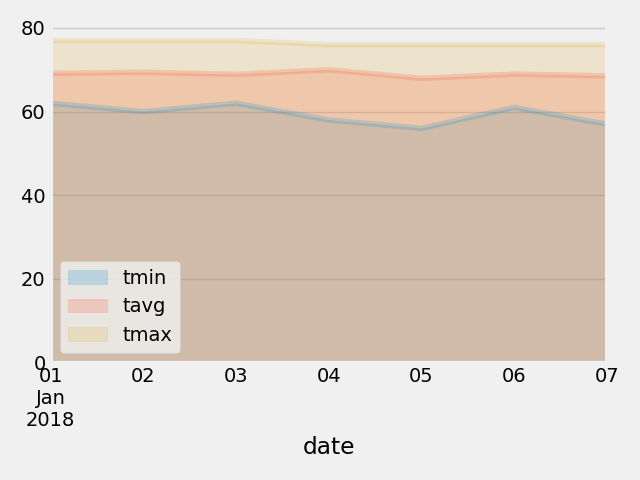

In [162]:
# Plot the daily normals as an area plot with `stacked=False`
trip_dates_df.plot(kind='area', stacked=False, alpha=0.2)
plt.tight_layout()
plt.savefig("Images/jw_daily_normals.png")

In [145]:
def stats(start=None, end=None):
    """Return TMIN, TAVG, TMAX."""

    # Select statement
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]

    if not end:
        # calculate TMIN, TAVG, TMAX for dates greater than start
        results = session.query(*sel).\
            filter(Measurement.date >= start).all()
        # Unravel results into a 1D array and convert to a list
        temps = list(np.ravel(results))
        return temps

    # calculate TMIN, TAVG, TMAX with start and stop
    results = session.query(*sel).\
        filter(Measurement.date >= start).\
        filter(Measurement.date <= end).all()
    # Unravel results into a 1D array and convert to a list
    temps = list(np.ravel(results))
    return temps
stats('2012-02-28', '2013-03-05')

[54.0, 72.20676691729324, 86.0]